<a href="https://colab.research.google.com/github/aman200-4/Blockchain-Transaction-Analysis-DL/blob/main/Blockchain-Transaction-Analysis-DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 867.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv("/content/transaction dataset.csv")  # Upload your file here
df.head()


,transaction_id,timestamp,from_address,to_address,transaction_value,transaction_fee,gas_used,block_number,is_contract,label,time_diff_from_prev_txn,degree_centrality,in_degree,out_degree,avg_txn_value,txn_count_last_24h
0,txn_0,09-02-2024 18:35,0x81a554681d9f42f92484bc2f07ba774d1fc3a5f8,0x4b072237cb4ecb8cd2e3123288043fab19cb7ca1,2.4925,0.00078,48363,1662202,0,0,2000,0.2920,44,46,3.2366,73
1,txn_1,01-06-2024 22:56,0x6fc57c86a8178b80e66432a24a2a43c655700a07,0x2357abd86ced2148722fbe6ef6b2559b56f07dcb,3.4093,0.00596,364182,1667247,1,0,1681,0.9296,39,44,0.2884,30
2,txn_2,27-12-2023 21:38,0x1281df3b00129f288401d3522a2af20aab99a14f,0xd8625e36975659202f18985f2df0aa5c11478dc5,2.0422,0.00913,634222,1288359,1,0,325,0.6691,24,0,0.6668,49
3,txn_3,21-05-2022 08:34,0x39cf48d17104c181ab3d4f133dc5f6d4735cd84a,0x965a3e0b412d3dccecf527f48806d9a408a48895,4.2312,0.00370,551125,1577084,0,0,1156,0.0241,23,47,1.7480,9
4,txn_4,22-02-2022 11:14,0x4085334883784b1a55eedf5f3f131d6d7ace900b,0x050442fa3a09f036627985aff32faebd39e920bb,3.1681,0.00129,753437,1432872,0,0,1408,0.6094,23,39,0.9105,74


In [4]:
# ✅ STEP 4: ENCODE ADDRESSES
le = LabelEncoder()
df['from_id'] = le.fit_transform(df['from_address'])
df['to_id'] = le.fit_transform(df['to_address'])


In [5]:
# ✅ STEP 5: NODE FEATURES
num_nodes = max(df['from_id'].max(), df['to_id'].max()) + 1
node_features = torch.zeros((num_nodes, 3))
for _, row in df.iterrows():
    node_features[row['from_id']] = torch.tensor([
        row['degree_centrality'],
        row['in_degree'],
        row['out_degree']
    ])



In [6]:
# ✅ STEP 6: EDGES & LABELS
import numpy as np

# Convert edge list to NumPy array first, then to tensor
edge_array = np.array([df['from_id'].values, df['to_id'].values])
edge_index = torch.from_numpy(edge_array).long()


In [7]:
# ✅ STEP 7: DEFINE GCN
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [8]:
from torch_geometric.data import Data

# Assuming you already mapped wallet addresses to IDs
# and created node features and edge_index

# labels should be a tensor of shape [num_nodes], dtype long
import torch

labels = torch.zeros(num_nodes, dtype=torch.long)
for _, row in df.iterrows():
    labels[row['from_id']] = int(row['label'])  # Or 'from_idx' if using remapped index

# Final data object
data = Data(x=node_features, edge_index=edge_index, y=labels)


In [9]:
# ✅ STEP 8: TRAINING
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(3, 16, 2).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 9.9802
Epoch 2, Loss: 8.0033
Epoch 3, Loss: 6.1896
Epoch 4, Loss: 4.4970
Epoch 5, Loss: 2.9315
Epoch 6, Loss: 1.6119
Epoch 7, Loss: 0.7401
Epoch 8, Loss: 0.3587
Epoch 9, Loss: 0.2653
Epoch 10, Loss: 0.2781
Epoch 11, Loss: 0.3198
Epoch 12, Loss: 0.3659
Epoch 13, Loss: 0.4092
Epoch 14, Loss: 0.4478
Epoch 15, Loss: 0.4813
Epoch 16, Loss: 0.5099
Epoch 17, Loss: 0.5339
Epoch 18, Loss: 0.5536
Epoch 19, Loss: 0.5693
Epoch 20, Loss: 0.5815
Epoch 21, Loss: 0.5904
Epoch 22, Loss: 0.5964
Epoch 23, Loss: 0.5997
Epoch 24, Loss: 0.6006
Epoch 25, Loss: 0.5994
Epoch 26, Loss: 0.5963
Epoch 27, Loss: 0.5916
Epoch 28, Loss: 0.5854
Epoch 29, Loss: 0.5779
Epoch 30, Loss: 0.5692
Epoch 31, Loss: 0.5597
Epoch 32, Loss: 0.5493
Epoch 33, Loss: 0.5382
Epoch 34, Loss: 0.5265
Epoch 35, Loss: 0.5143
Epoch 36, Loss: 0.5017
Epoch 37, Loss: 0.4888
Epoch 38, Loss: 0.4757
Epoch 39, Loss: 0.4623
Epoch 40, Loss: 0.4489
Epoch 41, Loss: 0.4355
Epoch 42, Loss: 0.4220
Epoch 43, Loss: 0.4086
Epoch 44, Loss: 0.39

In [10]:
# ✅ STEP 9: EVALUATE
model.eval()
_, pred = model(data).max(dim=1)
acc = int((pred == data.y).sum()) / int(data.num_nodes)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9475


In [11]:
import networkx as nx
import matplotlib.pyplot as plt


Show Full Transaction Graph

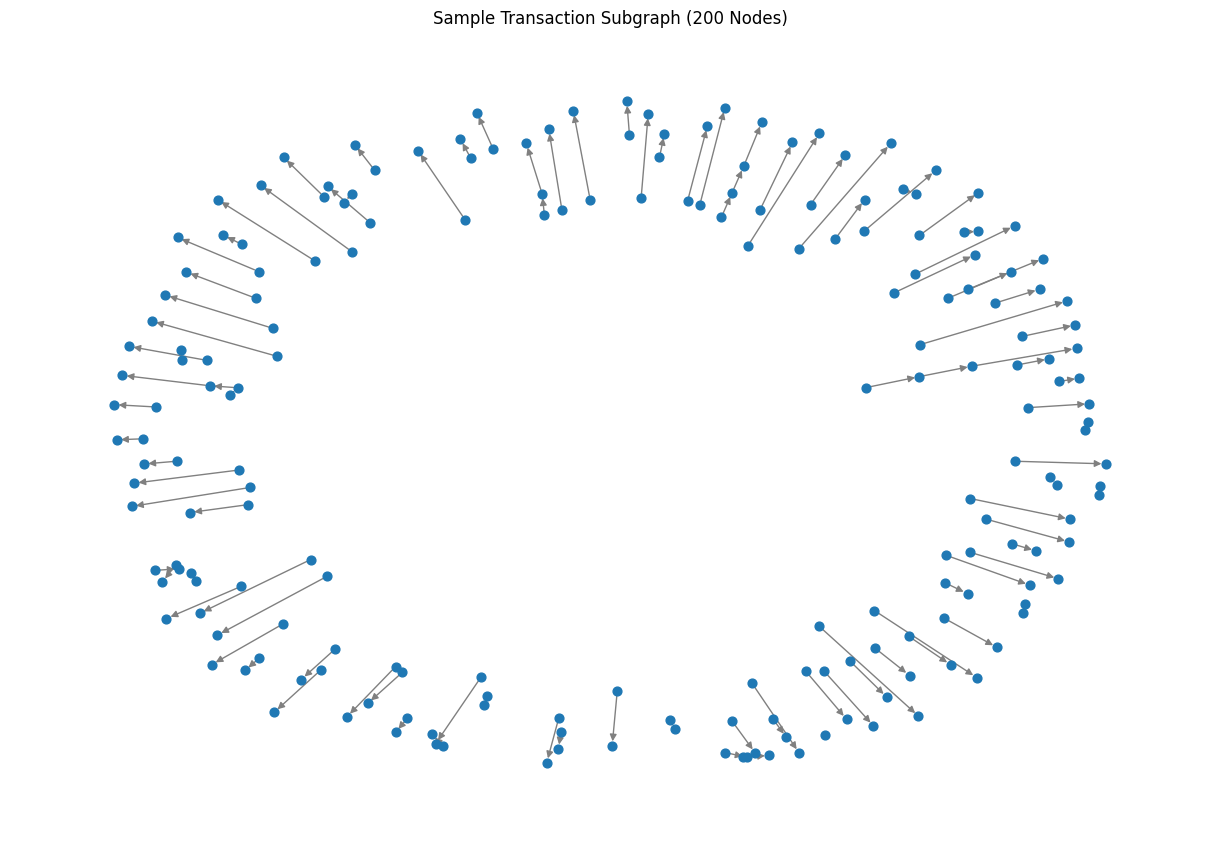

In [12]:
# Create a directed graph from edges
G = nx.DiGraph()
edges = edge_index.cpu().numpy().T  # shape (num_edges, 2)
G.add_edges_from(edges)

# Fix 1: Plot only a subgraph if the full graph is too dense
# Select first 200 nodes for clarity
sub_nodes = list(G.nodes)[:200]
H = G.subgraph(sub_nodes)

# Fix 2: Use spring layout for better visualization
pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(H, pos, node_size=40, arrows=True, with_labels=False, edge_color='gray')
plt.title("Sample Transaction Subgraph (200 Nodes)")
plt.show()


Label-Based Graph (Red = Fraud, Green = Normal)

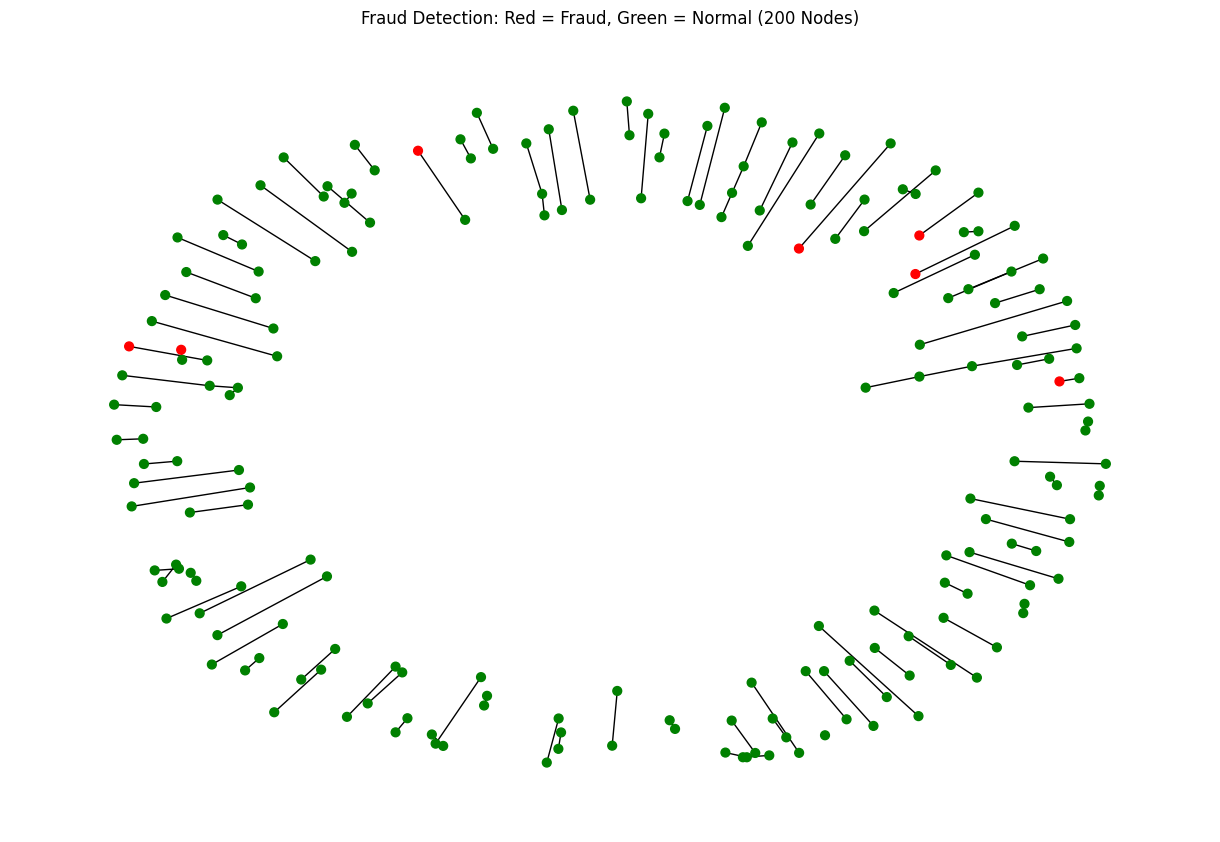

In [13]:
# Step 1: Build graph
G = nx.DiGraph()
edges = edge_index.cpu().numpy().T
G.add_edges_from(edges)

# Step 2: Subgraph (first 200 nodes)
sub_nodes = list(G.nodes)[:200]
H = G.subgraph(sub_nodes)

# Step 3: Get colors based on labels
colors = []
for node in H.nodes():
    label = data.y[node].item()
    colors.append('red' if label == 1 else 'green')

# Step 4: Draw with layout
pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(H, pos, node_color=colors, node_size=40, arrows=False, with_labels=False)
plt.title("Fraud Detection: Red = Fraud, Green = Normal (200 Nodes)")
plt.show()


Suspicious Score Heatmap (from GCN)

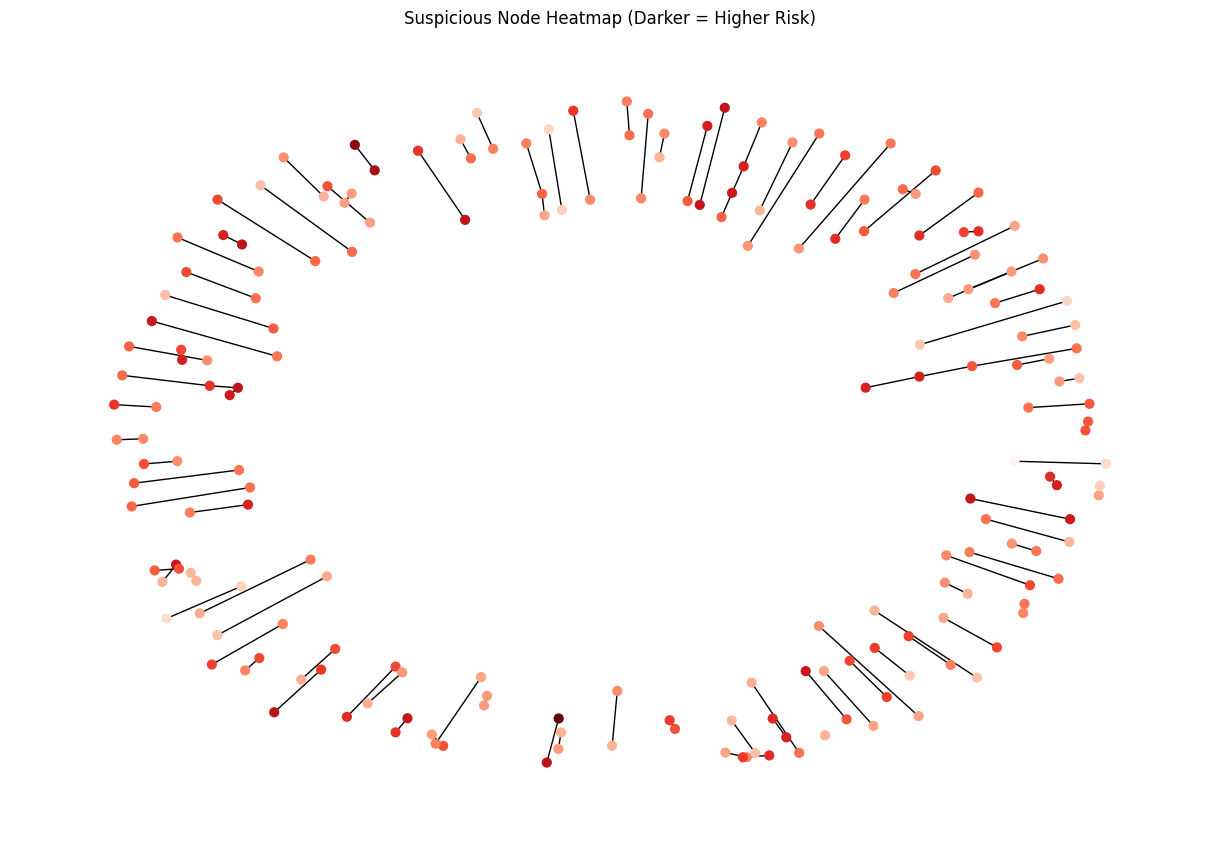

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm  # <-- Add this line
import networkx as nx
import numpy as np

# Step 1: Get the suspicious scores from the GCN output
model.eval()
output = model(data)
fraud_scores = output[:, 1].detach().cpu().numpy()  # Second column = fraud score

# Step 2: Build the full graph
G = nx.DiGraph()
edges = edge_index.cpu().numpy().T
G.add_edges_from(edges)

# Step 3: Create a subgraph of 200 nodes (with at least 1 neighbor)
sub_nodes = [node for node in G.nodes if len(list(G.neighbors(node))) > 0][:200]
H = G.subgraph(sub_nodes)

# Step 4: Extract fraud scores for only nodes in the subgraph
sub_scores = np.array([fraud_scores[node] for node in H.nodes()])
colors = cm.Reds((sub_scores - sub_scores.min()) / (sub_scores.max() - sub_scores.min()))

# Step 5: Plot the graph
pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(12, 8))
nx.draw(H, pos, node_color=colors, node_size=40, arrows=False, with_labels=False)
plt.title("Suspicious Node Heatmap (Darker = Higher Risk)")
plt.show()


 Top Suspicious Nodes Table or Graph

In [15]:
# Get fraud prediction scores
model.eval()
scores = model(data)[:, 1].detach().cpu().numpy()  # Class 1 = fraud

# Top 10 suspicious nodes
import numpy as np
top_indices = np.argsort(scores)[-10:][::-1]

print("🔎 Top 10 Suspicious Wallets:")
for i in top_indices:
    print(f"Node {i}, Fraud Score: {scores[i]:.4f}")


🔎 Top 10 Suspicious Wallets:
Node 8977, Fraud Score: -2.6917
Node 7893, Fraud Score: -2.7591
Node 1009, Fraud Score: -2.7722
Node 2944, Fraud Score: -2.8944
Node 3106, Fraud Score: -2.9618
Node 8791, Fraud Score: -3.0086
Node 6770, Fraud Score: -3.1741
Node 4323, Fraud Score: -3.1799
Node 9747, Fraud Score: -3.2491
Node 6381, Fraud Score: -3.2806


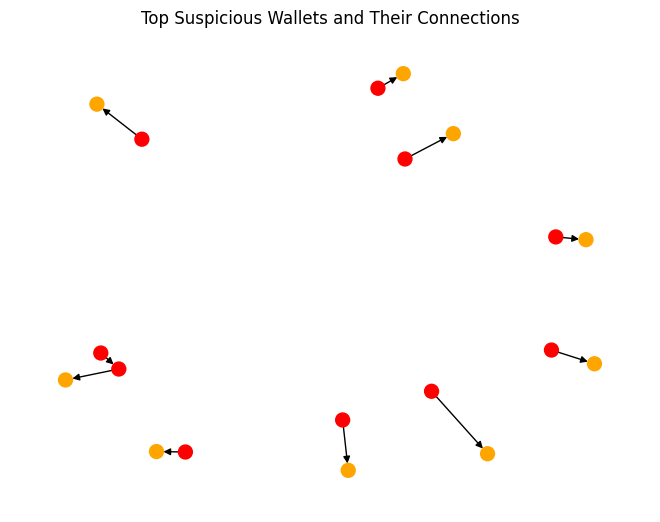

In [16]:
top_nodes = top_indices.tolist()
neighbors = set()
for node in top_nodes:
    neighbors.update(G.neighbors(node))
focus_nodes = list(set(top_nodes + list(neighbors)))
H_top = G.subgraph(focus_nodes)

pos = nx.spring_layout(H_top, seed=42)
color_map = ['red' if node in top_nodes else 'orange' for node in H_top.nodes()]
nx.draw(H_top, pos, node_color=color_map, node_size=100, with_labels=False)
plt.title("Top Suspicious Wallets and Their Connections")
plt.show()


autoencoder part (Node-Level Feature Engineering)

In [18]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/transaction dataset.csv")


# Display first few rows of the dataset
print("Dataset Sample:")
print(df.head())

# Select relevant features (you can modify this based on your dataset)
features = df[['degree_centrality', 'in_degree', 'out_degree', 'txn_count_last_24h', 'time_diff_from_prev_txn']].values

# Normalize the features using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Display the scaled features
print("\nScaled Features Sample:")
print(features_scaled[:5])

# Convert to torch tensor
X = torch.tensor(features_scaled, dtype=torch.float32)

# Split the dataset into training and testing sets (70-30 split)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# Display the size of the training and testing datasets
print(f"\nTraining Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Dataset Sample:
  transaction_id         timestamp  \
0          txn_0  09-02-2024 18:35   
1          txn_1  01-06-2024 22:56   
2          txn_2  27-12-2023 21:38   
3          txn_3  21-05-2022 08:34   
4          txn_4  22-02-2022 11:14   

                                 from_address  \
0  0x81a554681d9f42f92484bc2f07ba774d1fc3a5f8   
1  0x6fc57c86a8178b80e66432a24a2a43c655700a07   
2  0x1281df3b00129f288401d3522a2af20aab99a14f   
3  0x39cf48d17104c181ab3d4f133dc5f6d4735cd84a   
4  0x4085334883784b1a55eedf5f3f131d6d7ace900b   

                                   to_address  transaction_value  \
0  0x4b072237cb4ecb8cd2e3123288043fab19cb7ca1             2.4925   
1  0x2357abd86ced2148722fbe6ef6b2559b56f07dcb             3.4093   
2  0xd8625e36975659202f18985f2df0aa5c11478dc5             2.0422   
3  0x965a3e0b412d3dccecf527f48806d9a408a48895             4.2312   
4  0x050442fa3a09f036627985aff32faebd39e920bb             3.1681   

   transaction_fee  gas_used  block_number  is_cont

In [19]:
import torch.nn as nn

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder (compressing input to a smaller dimension)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        # Decoder (reconstructing the input from the encoding)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Ensure output is between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
input_dim = X.shape[1]  # Number of features
encoding_dim = 3  # Adjust for deeper or more compressed encoding
model = Autoencoder(input_dim, encoding_dim)

# Display the model architecture
print("\nAutoencoder Model Architecture:")
print(model)



Autoencoder Model Architecture:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=5, bias=True)
    (3): Sigmoid()
  )
)


In [20]:
import torch.optim as optim
import torch.nn.functional as F

# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop (100 epochs)
epochs = 100
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Zero the gradients before the backward pass

    # Forward pass
    reconstructed = model(X_train)

    # Compute the loss (MSE)
    loss = criterion(reconstructed, X_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.2412
Epoch 10, Loss: 1.1721
Epoch 20, Loss: 1.1007
Epoch 30, Loss: 1.0173
Epoch 40, Loss: 0.9326
Epoch 50, Loss: 0.8658
Epoch 60, Loss: 0.8110
Epoch 70, Loss: 0.7692
Epoch 80, Loss: 0.7436
Epoch 90, Loss: 0.7280


In [21]:
# Evaluate the model on the test set (without gradient computation)
model.eval()  # Set the model to evaluation mode

# Calculate the reconstruction error (Mean Squared Error) on the test set
with torch.no_grad():  # No gradients are needed for evaluation
    reconstructed = model(X_test)
    mse = torch.mean((reconstructed - X_test) ** 2, axis=1)

# Display the MSE values for the first 5 test samples
print("\nMean Squared Error for First 5 Test Samples:")
print(mse[:5])

# Define anomaly threshold (e.g., 3 standard deviations above the mean)
threshold = mse.mean() + 3 * mse.std()

# Detect anomalies (values above the threshold)
anomalies = mse > threshold
print(f"\nAnomalies detected: {anomalies.sum().item()} out of {len(mse)} test samples")



Mean Squared Error for First 5 Test Samples:
tensor([0.2248, 0.9532, 0.1569, 0.7848, 1.3563])

Anomalies detected: 34 out of 3000 test samples


Epoch [1/50], Loss: 0.0839
Epoch [2/50], Loss: 0.0838
Epoch [3/50], Loss: 0.0836
Epoch [4/50], Loss: 0.0835
Epoch [5/50], Loss: 0.0834
Epoch [6/50], Loss: 0.0833
Epoch [7/50], Loss: 0.0832
Epoch [8/50], Loss: 0.0831
Epoch [9/50], Loss: 0.0830
Epoch [10/50], Loss: 0.0829
Epoch [11/50], Loss: 0.0828
Epoch [12/50], Loss: 0.0827
Epoch [13/50], Loss: 0.0826
Epoch [14/50], Loss: 0.0825
Epoch [15/50], Loss: 0.0824
Epoch [16/50], Loss: 0.0822
Epoch [17/50], Loss: 0.0821
Epoch [18/50], Loss: 0.0820
Epoch [19/50], Loss: 0.0818
Epoch [20/50], Loss: 0.0817
Epoch [21/50], Loss: 0.0815
Epoch [22/50], Loss: 0.0813
Epoch [23/50], Loss: 0.0811
Epoch [24/50], Loss: 0.0809
Epoch [25/50], Loss: 0.0807
Epoch [26/50], Loss: 0.0805
Epoch [27/50], Loss: 0.0803
Epoch [28/50], Loss: 0.0801
Epoch [29/50], Loss: 0.0799
Epoch [30/50], Loss: 0.0796
Epoch [31/50], Loss: 0.0794
Epoch [32/50], Loss: 0.0791
Epoch [33/50], Loss: 0.0788
Epoch [34/50], Loss: 0.0785
Epoch [35/50], Loss: 0.0782
Epoch [36/50], Loss: 0.0779
E

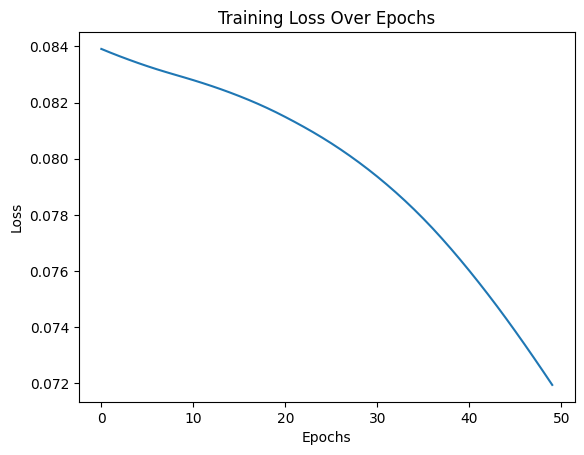

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Example: Replace this with your actual data
# Assuming X_train is your dataset (NumPy array, or Pandas DataFrame, etc.)
# For example, let's simulate some random data for illustration:
import numpy as np
X_train = np.random.rand(1000, 30)  # 1000 samples, 30 features (replace with your dataset)

# Convert to PyTorch tensor
input_data = torch.tensor(X_train, dtype=torch.float32)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Sigmoid for output in range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  # Number of features in your dataset
hidden_dim = 64
latent_dim = 32

model = Autoencoder(input_dim, hidden_dim, latent_dim)
criterion = nn.MSELoss()  # MSE loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    reconstructed = model(input_data)
    loss = criterion(reconstructed, input_data)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the training loss
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


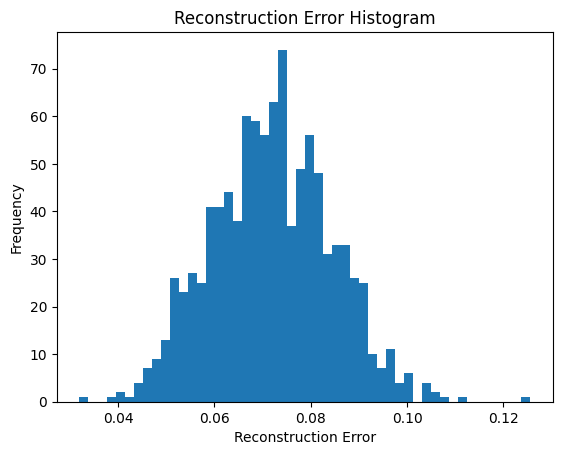

Number of anomalies detected: 50


In [23]:
# Compute reconstruction error
reconstruction_error = torch.mean((input_data - reconstructed) ** 2, dim=1)

# Plot the reconstruction error
plt.hist(reconstruction_error.detach().numpy(), bins=50)
plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Flag transactions with high reconstruction error as anomalies
threshold = np.percentile(reconstruction_error.detach().numpy(), 95)
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {anomalies.sum().item()}")


rnn and lstm

In [24]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/transaction dataset.csv")

# Convert 'timestamp' column to datetime format (if it's not already numeric)
# If already numeric (e.g., UNIX time), you can skip the conversion
# df['timestamp'] = pd.to_datetime(df['timestamp'])  # Uncomment if needed

# Sort by timestamp
df_sorted = df.sort_values('timestamp').reset_index(drop=True)

# Display a few rows to confirm
print("Dataset after sorting by timestamp:")
print(df_sorted[['timestamp', 'transaction_id']].head())


Dataset after sorting by timestamp:
          timestamp transaction_id
0  01-01-2022 02:18       txn_3163
1  01-01-2022 02:28       txn_6167
2  01-01-2022 02:41       txn_6146
3  01-01-2022 06:38       txn_8582
4  01-01-2022 12:00       txn_5848


In [30]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

# Load and sort dataset by timestamp (already sorted as per earlier step)
df = pd.read_csv('/content/transaction dataset.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d-%m-%Y %H:%M')
df = df.sort_values('timestamp')

# Select relevant time-series features
features = ['degree_centrality', 'in_degree', 'out_degree', 'txn_count_last_24h', 'time_diff_from_prev_txn']
data = df[features].values

# Normalize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert to torch tensor
data_scaled = torch.tensor(data_scaled, dtype=torch.float32)

# Create sequences for LSTM (e.g., lookback window = 10)
def create_sequences(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])  # Predicting next time step
    return torch.stack(X), torch.stack(y)

sequence_length = 10
X_seq, y_seq = create_sequences(data_scaled, sequence_length)

print("Input Sequence Shape:", X_seq.shape)
print("Target Sequence Shape:", y_seq.shape)

Input Sequence Shape: torch.Size([9990, 10, 5])
Target Sequence Shape: torch.Size([9990, 5])


In [27]:
import torch.nn as nn
import torch.optim as optim

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Use last time step's output
        return out

# Model hyperparameters
input_size = 5
hidden_size = 64
num_layers = 2
output_size = 5  # Predict all 5 features

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_seq)
    loss = criterion(outputs, y_seq)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")


Epoch [10/50], Loss: 0.999750
Epoch [20/50], Loss: 0.999348
Epoch [30/50], Loss: 0.998984
Epoch [40/50], Loss: 0.998571
Epoch [50/50], Loss: 0.997989


In [28]:
from sklearn.model_selection import train_test_split

# Reuse sequence data from earlier
X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)

# Train-test split (e.g., 80-20)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq_tensor, y_seq_tensor, test_size=0.2, random_state=42
)

# Optional: Print shapes to verify
print("X_test_seq shape:", X_test_seq.shape)
print("y_test_seq shape:", y_test_seq.shape)


X_test_seq shape: torch.Size([1998, 10, 5])
y_test_seq shape: torch.Size([1998, 5])


/tmp/ipython-input-28-3495844528.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
/tmp/ipython-input-28-3495844528.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)


In [31]:
import torch.nn.functional as F

# Evaluate on test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_seq)
    test_loss = F.mse_loss(predictions, y_test_seq)

print(f"Test MSE Loss: {test_loss.item():.6f}")


Test MSE Loss: 0.986667


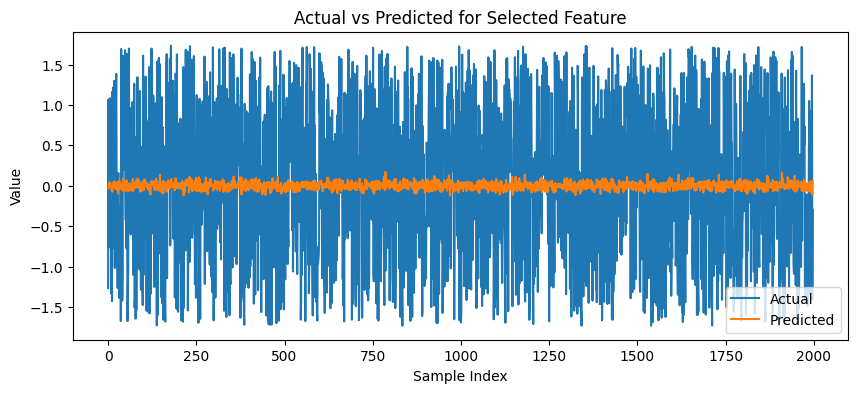

In [32]:
import numpy as np

# Convert tensors to numpy
actual = y_test_seq.numpy()
predicted = model(X_test_seq).detach().numpy()

# Ensure they are 2D
if actual.ndim == 1:
    actual = actual.reshape(-1, 1)
if predicted.ndim == 1:
    predicted = predicted.reshape(-1, 1)

# Index of the feature to visualize (e.g., 4 for 'txn_count_last_24h')
feature_idx = 4 if actual.shape[1] > 4 else 0  # fallback in case dimensions are small

# Plot actual vs predicted for one feature
plt.figure(figsize=(10, 4))
plt.plot(actual[:, feature_idx], label='Actual')
plt.plot(predicted[:, feature_idx], label='Predicted')
plt.title('Actual vs Predicted for Selected Feature')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Already predicted and actual
y_true = actual
y_pred = predicted

# Compute metrics for each feature
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"🔍 Prediction Error Analysis:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


🔍 Prediction Error Analysis:
Mean Absolute Error (MAE): 0.8560
Mean Squared Error (MSE): 0.9867
Root Mean Squared Error (RMSE): 0.9933
R² Score: 0.0018


end😊